# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl




# 1. Using custom mechanisms

Here we demonstrate how to compile custom active mechanisms. Most models of membrane/intracellular mechanisms are written in the NMODL language (see the links above) and the files should have an extension ".mod". In order to use those mod files (therefore active mechanisms), you first need to compile them, and, if necessary, direct NEURON to load the compiled library.

Here our first example is `MorrisLecar.mod`, which implements the Morris-Lecar ion channels, used in Rinzel and Ermentrout. If you look into the file, it looks like:

```
TITLE Morris-Lecar spiking dynamics

....

NEURON {
  SUFFIX ml
  USEION k READ ek WRITE ik
  USEION na READ ena WRITE ina
  NONSPECIFIC_CURRENT il
  RANGE gnabar, gkbar, gleak, el, ina, ik, il, w, winit
  RANGE phi, betam, gammam, betaw, gammaw
  THREADSAFE minf, winf, tauw
}

.....

```

The first part contains important information: `ml`, after `SUFFIX`, is the name of this mechanism in NEURON, just as `pas` and `hh` that we have seen before. `USEION` tells you which ions are used. In particular, it writes `ik` and `ina`, which correspond to the K+ and Na+ current. `RANGE` specifies the variables that you can read and write in NEURON.

To compile this, run `nrnivmodl` in the terminal, or simply 

In [1]:
%%bash

cd mod.files
nrnivmodl

/root/Documents/class_3/mod.files
CaT.mod HH2.mod MorrisLecar.mod ca.mod caL3d.mod cad.mod exp2synNMDA.mod h.mod kca.mod kir.mod km.mod kv.mod na.mod netstim2.mod
CaT.mod HH2.mod MorrisLecar.mod ca.mod caL3d.mod cad.mod exp2synNMDA.mod h.mod kca.mod kir.mod km.mod kv.mod na.mod netstim2.mod
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=link mpicc -module  -O3 -fPIC -fno-strict-aliasing -msse3    -o libnrnmech.la -rpath "/usr/local/nrn/x86_64/lib"  CaT.lo HH2.lo MorrisLecar.lo ca.lo caL3d.lo cad.lo exp2synNMDA.lo h.lo kca.lo kir.lo km.lo kv.lo na.lo netstim2.lo mod_func.lo 

Now, we first load the necessary modules and create a single compartment cell,

In [2]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt

load_mechanisms('./mod.files')

True

In [3]:
# Single compartment cell
soma = h.Section(name="soma")
soma.L = 20
soma.diam = 20

# Add a current clamp electrode
ic = h.IClamp(soma(0.5))

Then, we insert the "hh2" mechanism (in `mod.files/HH2.mod`) and check the cells,

In [4]:
soma.insert("hh2")
soma.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'hh2': {'gnabar': [0.003],
   'gkbar': [0.005],
   'vtraub': [-63.0],
   'm_inf': [0.0],
   'h_inf': [0.0],
   'n_inf': [0.0],
   'tau_m': [0.0],
   'tau_h': [0.0],
   'tau_n': [0.0],
   'm_exp': [0.0],
   'h_exp': [0.0],
   'n_exp': [0.0],
   'm': [0.0],
   'h': [0.0],
   'n': [0.0]}},
 'ions': {'na': {'ena': [50.0],
   'nai': [10.0],
   'nao': [140.0],
   'ina': [0.0],
   'dina_dv_': [0.0]},
  'k': {'ek': [-77.0],
   'ki': [54.4],
   'ko': [2.5],
   'ik': [0.0],
   'dik_dv_': [0.0]}},
 'morphology': {'L': 20.0,
  'diam': [20.0],
  'pts3d': [],
  'parent': None,
  'trueparent': None},
 'nseg': 1,
 'Ra': 35.4,
 'cm': [1.0]}

In [5]:
# Prepare a simulation for 300 ms,
h.tstop = 300

# Current injection of 10 pA for 200 ms
ic.delay = 50
ic.dur = 200
ic.amp = 0.01 # 10 pA

In [6]:
# We set the temperature to 35°C to simulate a mammalian neuron,
h.celsius = 35

# Record the time and voltage,
dt_rec = 0.1
t = h.Vector()
v = h.Vector()
t.record(h._ref_t, 0.1)
v.record(soma(0.5)._ref_v, dt_rec)


Vector[4]

Here, we add a `NetCon` object that will monitor the membrane potential of the cell and detect events with `v` crossing -20 mV. Since this `NetCon` does not need to deliver events to anything else, we connect it to `None`. Then, we can record the event times to a vector, which lets us to record spike times, detected by a voltage threshold.

In [7]:
nc = h.NetCon(soma(0.5)._ref_v, None, -20, 0, 1)
tspike = h.Vector()
nc.record(tspike)

0.0

[Text(0,0.5,'v (mv)'), Text(0.5,0,'time (ms)')]

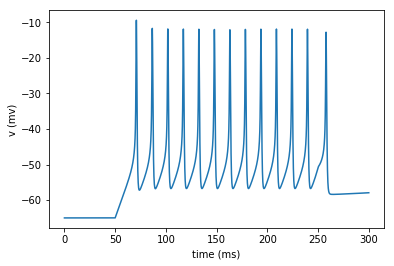

In [8]:
# Run the simulation and plot the result

h.run()

_, ax = plt.subplots()

ax.plot(t, v)
ax.set(xlabel="time (ms)", ylabel = "v (mv)")


Here We print the spike times. Note that we used `.as_numpy` to transform a NEURON `Vector` to a numpy array

In [9]:
print(tspike.as_numpy())

[ 70.575  86.275 101.6   116.9   132.175 147.475 162.75  178.05  193.325
 208.6   223.9   239.175 257.5  ]


## Pyramidal cell example

Now let's simulate the fully active pyramidal cell model. **Please make sure that you restart the kernel at this point.**

In [1]:
from neuron import h, gui
from neuron import load_mechanisms
import libcell

import numpy as np
import matplotlib.pyplot as plt
load_mechanisms('./mod.files')

True

First we defined a passive cell,

In [2]:
cell = libcell.L23()

	0 
	1 
	1 
	1 
	1 


And then, we call a function in `libcell.py` to embed active mechanisms everywhere,`

In [3]:
libcell.init_active(cell, axon=True, soma=True, dend=True, dendNa=True, dendCa=True)
cell.soma.psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287,
    0.00014285714285714287],
   'e': [-75.0, -75.0, -75.0, -75.0, -75.0, -75.0, -75.0],
   'i': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
  'it': {'gbar': [0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
   'gca': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'minf': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'hinf': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'mtau': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'htau': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'm': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'h': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]},
  'ca': {'gbar': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
   'gca': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'minf': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'hinf': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
   'mtau': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

To test the excitability of the cell, we add a current clamp electrode at soma,

In [4]:
ic = h.IClamp(cell.soma(0.5))

Let's define a function to do a virtual current clamp experiment,

In [5]:
def do_current_clamp(current_injected):
    
    # should not forget setting the temperature...
    h.celsius = 35
    
    # Simulation length = 300 ms
    h.tstop = 300

    # Current injection for 200 ms
    ic.delay = 50
    ic.dur = 200
    ic.amp = current_injected


    dt_rec = 0.1
    t = h.Vector()
    v = h.Vector()
    v.record(cell.soma(1)._ref_v, dt_rec)
    t.record(h._ref_t, dt_rec)

    # We set the initial voltage to -75 mV and run the simulation
    h.v_init = -75
    h.init()
    h.run()
    
    # Here we plot the result
    _, ax = plt.subplots()

    ax.plot(t, v)
    ax.set(xlabel="time (ms)", ylabel = "v (mv)")

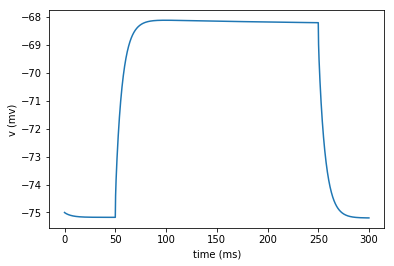

In [6]:
do_current_clamp(0.1) # 100 pA injection; the cell is still in a subthreshold regime

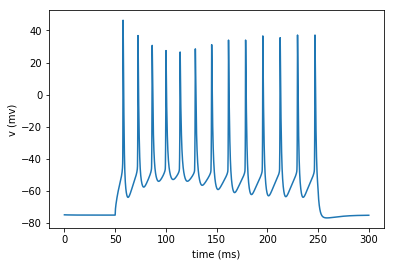

In [7]:
do_current_clamp(0.5) # 500 pA injection will give you spikes

## Adding synapses

Here we will add some synapses to the cell. These functions are copied from `libcell.py` and modified to connect each synapse to external artificial spike generators.

In [8]:
def add_AMPAsyns(model, locs, stims, gmax=1, tau1=0.5, tau2=1):
    """inserts AMPA synapses into model at locs and connect them to stims.
    locs is a list of lists containing two numbers, such as [[0, 0.5]]. The first
    number denotes which dendritic compartement the synapse will be located
    and the second is a relative coordinate. For example, [[0, 0.5]] will embed
    one synapse at model.dends[0](0.5). gmax is a maximal conductance in uS.
    tau1 and tau2 are a rising and decay time constant in ms.
    """
    # we store synapses and NetCons in a list
    model.AMPAlist = []
    model.ncAMPAlist = []
    
    # set in nS and convert to muS
    gmax = gmax/1000.
    
    for loc, stim in zip(locs, stims):
        # an AMPA synapse is `Exp2Syn` with a reversal potential = 0 mV
        AMPA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        AMPA.tau1 = tau1
        AMPA.tau2 = tau2
        
        # connect stim to the synapse
        NC = h.NetCon(stim, AMPA, 0, 0, gmax)
        model.AMPAlist.append(AMPA)
        model.ncAMPAlist.append(NC)

        
def add_NMDAsyns(model, locs, stims, gmax=1, tau1=2, tau2=20):
    """inserts NMDA synapses into model at locs and connect them to stims."""
    model.NMDAlist = []
    model.ncNMDAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # an NMDA synapse
        NMDA = h.Exp2SynNMDA(float(loc[1]), sec=model.dends[int(loc[0])])
        NMDA.tau1 = tau1
        NMDA.tau2 = tau2
        NC = h.NetCon(stim, NMDA, 0, 0, gmax)
        x = float(loc[1])
        model.NMDAlist.append(NMDA)
        model.ncNMDAlist.append(NC)

        
def add_GABAsyns(model, locs, stims, gmax=0.5, tau1=0.1, tau2=4, rev=-80):
    """insetrs GABA synapses into model at locs and connect them to stims."""
    model.GABAlist = []
    model.ncGABAlist = []
    gmax = gmax/1000.   # Set in nS and convert to muS
    for loc, stim in zip(locs, stims):
        # a GABA synapse is `Exp2Syn` with a reversal potential = rev mV 
        # (default value = -80 mV)
        GABA = h.Exp2Syn(float(loc[1]), sec=model.dends[int(loc[0])])
        GABA.tau1 = tau1
        GABA.tau2 = tau2
        GABA.e = rev
        NC = h.NetCon(stim, GABA, 0, 0, gmax)
        model.GABAlist.append(GABA)
        model.ncGABAlist.append(NC)

Lets add an AMPA+NMDA synapse at cell.dend\[0\](0.5) and connect it to an artificial spike generator.

In [9]:
# location = cell.dend[0](0.5)
locs = [[0, 0.5]]

# spiking frequency = 10 Hz, ISI = 1000/10 = 100 ms
fexc = 10

exc_stims = []
for loc in locs:
    exc_stims.append(h.NetStimFD()) # An articifial spike generator
    exc_stims[-1].noise = 0 # no noise
    exc_stims[-1].start = 150 # start from 150 ms
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc # set ISI

# Add an AMPA synapse connected to exc_stims
add_AMPAsyns(cell, locs, exc_stims)
# Add an NMDA synapse at the same location, also connected to exc_stims
add_NMDAsyns(cell, locs, exc_stims)


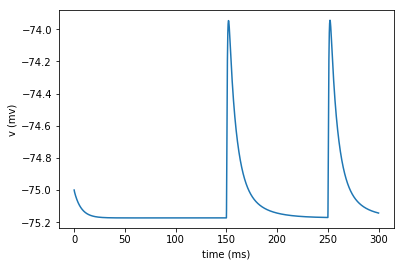

In [10]:
do_current_clamp(0.0) # Run a simulation with no current injection

Now let's try many more synapses, inserted at random locations! We first make a function to create random locations in the cell's dendrites.

In [11]:
def genRandomLocs(model, nsyn):
    """generates nsyn random locations distributed in model.dends."""
    locs = []
    for s in np.arange(0,nsyn):
        dend = np.random.randint(low=0, high=len(model.dends))
        pos = np.random.uniform()
        locs.append([dend, pos])
    return locs

And then, we create 100 excitatory and 20 inhibitory synapse locations.

In [12]:
n_exc = 100
n_inh = 20

exc_locs = genRandomLocs(cell, n_exc)
inh_locs = genRandomLocs(cell, n_inh)
inh_locs

[[3, 0.9596620203446448],
 [93, 0.20745394776256842],
 [52, 0.7046539553702855],
 [92, 0.5410657920875483],
 [21, 0.15399376861806435],
 [79, 0.8999672474271468],
 [72, 0.771220387101607],
 [16, 0.22734859510267458],
 [39, 0.7295337591918936],
 [71, 0.8704207373846552],
 [92, 0.5665697049123255],
 [46, 0.6064695079844813],
 [52, 0.6609058919934612],
 [76, 0.31546214533597927],
 [46, 0.2770410632226161],
 [9, 0.1200881672692462],
 [99, 0.11940451425868104],
 [91, 0.6608153357973886],
 [8, 0.3167715491928613],
 [102, 0.29437271903869655]]

We connect the excitatory synapses to spike generators, Poisson firing at 10 Hz. The inhibitory ones will be connected to another set of spike generators firing at 40 Hz.

In [13]:
# excitatory stims
fexc = 10 # 10 Hz
exc_stims = []
for loc in exc_locs:
    exc_stims.append(h.NetStimFD())
    exc_stims[-1].noise = 1 # maximally noisy stimulus
    exc_stims[-1].start = 0 # start from 0
    exc_stims[-1].duration = h.tstop
    exc_stims[-1].interval = 1000./fexc

add_AMPAsyns(cell, exc_locs, exc_stims)
add_NMDAsyns(cell, exc_locs, exc_stims)


# inhibitory stims
finh = 40 # 40 Hz
inh_stims = []
for loc in inh_locs:
    inh_stims.append(h.NetStimFD())
    inh_stims[-1].noise = 1 # maximally noisy stimulus
    inh_stims[-1].start = 0 # start from 0
    inh_stims[-1].duration = h.tstop
    inh_stims[-1].interval = 1000./fexc

add_GABAsyns(cell, inh_locs, inh_stims)

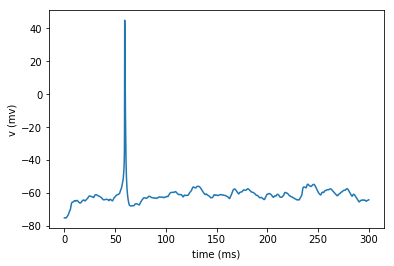

In [14]:
do_current_clamp(0.0) # Run a simulation with no current injection

---
# We will cover this part in the next class on April 9.

# 2. Cell objects

**Make sure that you reset the kernel at this point.** 

In Python, you can define custom data types that you can use to organize data and related operations. For example, so far we have worked with cell models in NEURON, which have common attributes and operations as:

1. Sections and segments,
2. Combining sections to define the morphology of a cell,
3. Active mechanisms and inserting them,
4. Synapses and connecting them to other cells, etc.


We can collect these into a cell object as follows:

In [ ]:
from neuron import h, gui
from neuron import load_mechanisms

import numpy as np
import matplotlib.pyplot as plt
load_mechanisms('./mod.files')


class Cell:
    """ Cell class"""
    
    # When a cell object is created this function is called first.
    # Note "self" in definition
    def __init__(self):
        
        self.synlist = []      # list of synapses in this cell

        # here are some operations to create a cell
        self.create_sections()
        self.build_topology()
        self.build_subsets()
        self.define_geometry()
        self.define_biophysics()
        self.create_synapses()

    # At this stage, we leave most of them unimplemented
    # This technique is called "the Template Method pattern" (https://sourcemaking.com/design_patterns/template_method)
    def create_sections(self):
        raise NotImplementedError("create_section() is not implemented.")

    def build_topology(self):
        raise NotImplementedError("build_topology() is not implemented.")
    
    def build_subsets(self):
        raise NotImplementedError("build_subsets() is not implemented.")

    def define_geometry(self):
        raise NotImplementedError("define_geometry() is not implemented.")

    def define_biophysics(self):
        raise NotImplementedError("define_biophysics() is not implemented.")

    def create_synapses(self):
        raise NotImplementedError("create_synapses() is not implemented.")
    
    # Here are something that will be commonly used by every cell
    # built based on this template
    
    def connect2target(self, target, thresh=0):
        """Make a new NetCon with this cell's membrane
        potential at the soma as the source (i.e. the spike detector)
        onto the target passed in (i.e. a synapse on a cell).
        Subclasses may override with other spike detectors."""
        nc = h.NetCon(self.soma(1)._ref_v, target, sec = self.soma)
        nc.threshold = thresh
        return nc


In [ ]:
cell1 = Cell()

It will generate an error whenever you fail to provide any necessary step to define a proper cell. To implement those steps, we _subclass_ `Cell` as:

In [ ]:
class MorrisLecar(Cell):
    """Single compartment passive neuron"""
    
    def create_sections(self):
        """create a soma"""
        self.soma = h.Section(name="soma", cell=self)

    def build_topology(self):
        pass # single compartment
    
    def build_subsets(self):
        pass # single compartment
    
    def define_geometry(self):
        self.soma.L = 15
        self.soma.diam = 15

    def define_biophysics(self):
        self.soma.insert('ml')
        
    def create_synapses(self):
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Excitatory
        self.synlist[-1].tau2 = 3.0
        
        self.synlist.append(h.Exp2Syn(self.soma(0.5))) # Inhibitory     
        self.synlist[-1].e = -75
        self.synlist[-1].tau1 = 1.0
        self.synlist[-1].tau2 = 7.0
    

In [ ]:
cell1.soma.psection()